# Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


# Preprocessing

In [2]:
df_train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

In [3]:
df_train.shape, df_test.shape

((6036000, 8), (4024000, 7))

In [4]:
df_train.head(8)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
5,6,1,20,50,0.169698,27.259866,0,12.867706
6,7,1,20,50,0.203708,27.127486,0,14.695562
7,8,1,20,50,0.237723,26.807732,0,15.890699


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,6036000.0,3.018000e+06,1.742443e+06,1.000000,1.509001e+06,3.018000e+06,4.527000e+06,6.036000e+06
breath_id,6036000.0,6.283886e+04,3.633526e+04,1.000000,3.137700e+04,6.276550e+04,9.430100e+04,1.257490e+05
R,6036000.0,2.703618e+01,1.959549e+01,5.000000,5.000000e+00,2.000000e+01,5.000000e+01,5.000000e+01
C,6036000.0,2.608072e+01,1.715231e+01,10.000000,1.000000e+01,2.000000e+01,5.000000e+01,5.000000e+01
time_step,6036000.0,1.307225e+00,7.659778e-01,0.000000,6.428995e-01,1.308123e+00,1.965502e+00,2.937238e+00
u_in,6036000.0,7.321615e+00,1.343470e+01,0.000000,3.936623e-01,4.386146e+00,4.983895e+00,1.000000e+02
u_out,6036000.0,6.204493e-01,4.852752e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
pressure,6036000.0,1.122041e+01,8.109703e+00,-1.895744,6.329607e+00,7.032628e+00,1.364103e+01,6.482099e+01


In [7]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
id,0,0.0
breath_id,0,0.0
R,0,0.0
C,0,0.0
time_step,0,0.0
u_in,0,0.0
u_out,0,0.0
pressure,0,0.0


In [8]:
df_train.drop(columns=['id', 'breath_id'], inplace=True)

In [9]:
cols = df_train.columns
for i in range(0, len(cols)):
    print(df_train[cols[i]].value_counts())
    print('****************************************\n')

50    2410080
5     1988800
20    1637120
Name: R, dtype: int64
****************************************

10    2244720
50    1971680
20    1819600
Name: C, dtype: int64
****************************************

0.000000    75450
0.031934       46
0.031935       44
0.031920       43
0.031938       43
            ...  
1.793088        1
1.827272        1
1.896594        1
1.930891        1
2.638017        1
Name: time_step, Length: 3767571, dtype: int64
****************************************

0.000000      1432253
100.000000      21739
1.277707           76
1.494747           70
0.058727           67
               ...   
1.116695            1
0.665753            1
0.782097            1
0.615699            1
1.482739            1
Name: u_in, Length: 4020300, dtype: int64
****************************************

1    3745032
0    2290968
Name: u_out, dtype: int64
****************************************

 6.399909     198642
 6.470211     188844
 6.329607     180688
 6.259305     1805

In [10]:
cols = df_train.columns
for i in range(0, len(cols)-1):
    print(cols[i])
    print(df_train[cols[i]].unique())
    print('****************************************\n')

R
[20 50  5]
****************************************

C
[50 20 10]
****************************************

time_step
[0.         0.03365231 0.06751442 ... 2.57140756 2.60474443 2.63801742]
****************************************

u_in
[ 0.08333401 18.38304147 22.50927777 ...  1.55897786  1.27266322
  1.48273915]
****************************************

u_out
[0 1]
****************************************



In [11]:
df_train

,R,C,time_step,u_in,u_out,pressure
0,20,50,0.000000,0.083334,0,5.837492
1,20,50,0.033652,18.383041,0,5.907794
2,20,50,0.067514,22.509278,0,7.876254
3,20,50,0.101542,22.808822,0,11.742872
4,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...
6035995,50,10,2.504603,1.489714,1,3.869032
6035996,50,10,2.537961,1.488497,1,3.869032
6035997,50,10,2.571408,1.558978,1,3.798729
6035998,50,10,2.604744,1.272663,1,4.079938


# Visualization

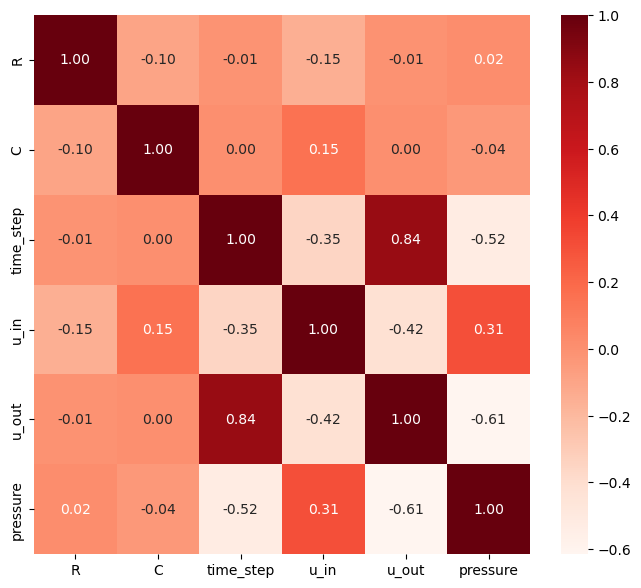

In [12]:
plt.figure(figsize=(8,7))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,fmt='.2f')
plt.show()

<Figure size 500x400 with 0 Axes>

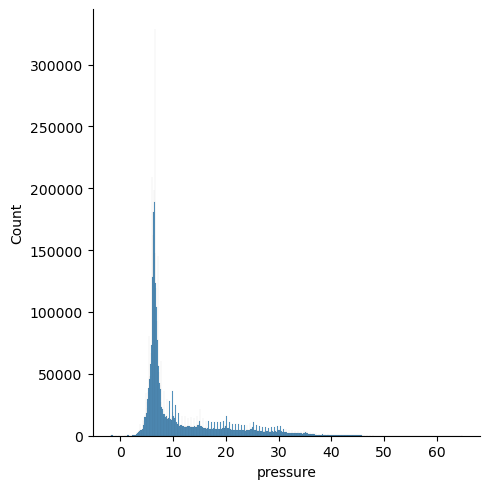

In [13]:
plt.figure(figsize=(5,4))
sns.displot(x=df_train['pressure'])

<AxesSubplot:xlabel='pressure'>

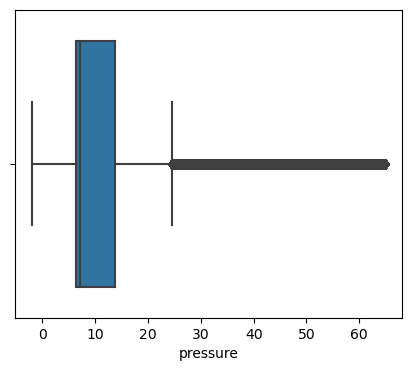

In [14]:
plt.figure(figsize=(5,4))
sns.boxplot(x=df_train['pressure'])

<AxesSubplot:xlabel='R', ylabel='count'>

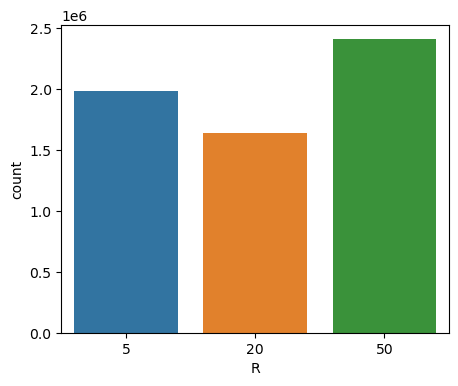

In [15]:
plt.figure(figsize=(5,4))
sns.countplot(x=df_train['R'])

<AxesSubplot:xlabel='C', ylabel='count'>

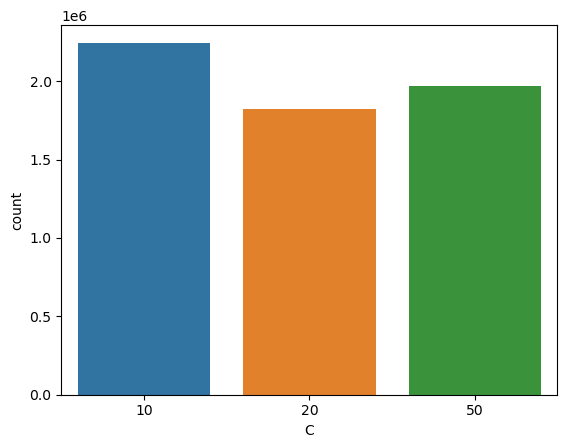

In [16]:
sns.countplot(x=df_train['C'])

<AxesSubplot:xlabel='u_in'>

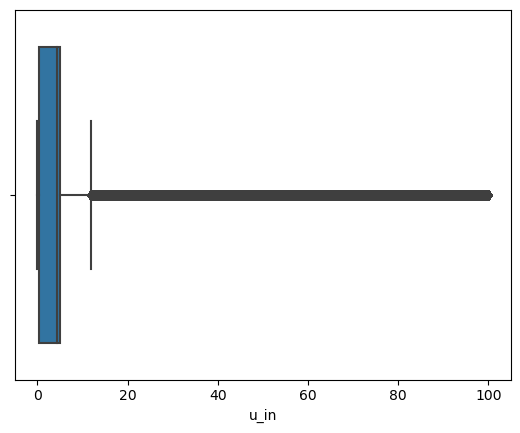

In [17]:
sns.boxplot(x=df_train['u_in'])

<AxesSubplot:xlabel='time_step'>

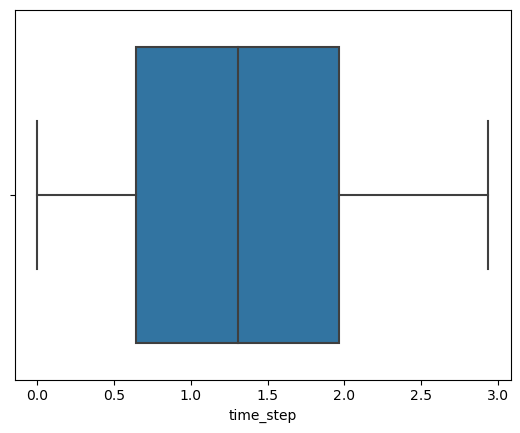

In [18]:
sns.boxplot(x=df_train['time_step'])

<AxesSubplot:xlabel='u_out', ylabel='count'>

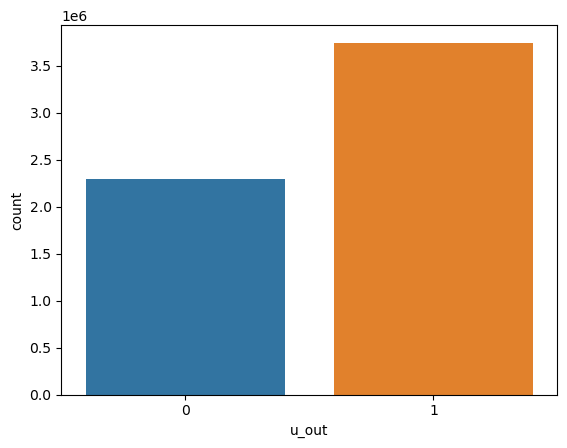

In [19]:
sns.countplot(x=df_train['u_out'])

# Feature Engineering

In [20]:
df_train['un_in_std'] = df_train['u_in'].transform(lambda x: (x - x.mean()) / x.std())
df_train['time_step_std'] = df_train['time_step'].transform(lambda x: (x - x.mean()) / x.std())

In [21]:
df_train['time_step_after'] = df_train[['time_step_std']].shift()
df_train['u_in_after'] = df_train[['un_in_std']].shift()
df_train['u_out_after'] = df_train[['u_out']].shift()
df_train['time_step_back'] = df_train[['time_step_std']].shift(-1)
df_train['u_in_back'] = df_train[['un_in_std']].shift(-1)
df_train['u_out_back'] = df_train[['u_out']].shift(-1)
df_train['time_step_after2'] = df_train[['time_step_std']].shift(2)
df_train['u_in_after2'] = df_train[['un_in_std']].shift(2)
df_train['u_out_after2'] = df_train[['u_out']].shift(2)
df_train['time_step_back2'] = df_train[['time_step_std']].shift(-2)
df_train['u_in_back2'] = df_train[['un_in_std']].shift(-2)
df_train['u_out_back2'] = df_train[['u_out']].shift(-2)
df_train['time_step_after3'] = df_train[['time_step_std']].shift(3)
df_train['u_in_after3'] = df_train[['un_in_std']].shift(3)
df_train['u_out_after3'] = df_train[['u_out']].shift(3)
df_train['time_step_back3'] = df_train[['time_step_std']].shift(-3)
df_train['u_in_back3'] = df_train[['un_in_std']].shift(-3)
df_train['u_out_back3'] = df_train[['u_out']].shift(-3)
df_train['time_step_after4'] = df_train[['time_step_std']].shift(4)
df_train['u_in_after4'] = df_train[['un_in_std']].shift(4)
df_train['u_out_after4'] = df_train[['u_out']].shift(4)
df_train['time_step_back4'] = df_train[['time_step_std']].shift(-4)
df_train['u_in_back4'] = df_train[['un_in_std']].shift(-4)
df_train['u_out_back4'] = df_train[['u_out']].shift(-4)
df_train['time_step_after5'] = df_train[['time_step_std']].shift(5)
df_train['u_in_after5'] = df_train[['un_in_std']].shift(5)
df_train['u_out_after5'] = df_train[['u_out']].shift(5)
df_train['time_step_back5'] = df_train[['time_step_std']].shift(-5)
df_train['u_in_back5'] = df_train[['un_in_std']].shift(-5)
df_train['u_out_back5'] = df_train[['u_out']].shift(-5)

In [22]:
df_train

,R,C,time_step,u_in,u_out,pressure,un_in_std,time_step_std,time_step_after,u_in_after,...,u_out_after4,time_step_back4,u_in_back4,u_out_back4,time_step_after5,u_in_after5,u_out_after5,time_step_back5,u_in_back5,u_out_back5
0,20,50,0.000000,0.083334,0,5.837492,-0.538775,-1.706609,NaN,NaN,...,NaN,-1.529378,1.342362,0.0,NaN,NaN,NaN,-1.485065,1.484086,0.0
1,20,50,0.033652,18.383041,0,5.907794,0.823347,-1.662676,-1.706609,-0.538775,...,NaN,-1.485065,1.484086,0.0,NaN,NaN,NaN,-1.440664,1.474232,0.0
2,20,50,0.067514,22.509278,0,7.876254,1.130480,-1.618468,-1.662676,0.823347,...,NaN,-1.440664,1.474232,0.0,NaN,NaN,NaN,-1.396257,1.450432,0.0
3,20,50,0.101542,22.808822,0,11.742872,1.152776,-1.574044,-1.618468,1.130480,...,NaN,-1.396257,1.450432,0.0,NaN,NaN,NaN,-1.351799,1.529107,0.0
4,20,50,0.135756,25.355850,0,12.234987,1.342362,-1.529378,-1.574044,1.152776,...,0.0,-1.351799,1.529107,0.0,NaN,NaN,NaN,-1.307470,1.562478,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,50,10,2.504603,1.489714,1,3.869032,-0.434092,1.563202,1.519583,-0.439228,...,1.0,1.737377,-0.434611,1.0,1.345285,-0.443207,1.0,NaN,NaN,NaN
6035996,50,10,2.537961,1.488497,1,3.869032,-0.434183,1.606751,1.563202,-0.434092,...,1.0,NaN,NaN,NaN,1.388937,-0.443579,1.0,NaN,NaN,NaN
6035997,50,10,2.571408,1.558978,1,3.798729,-0.428937,1.650417,1.606751,-0.434183,...,1.0,NaN,NaN,NaN,1.432461,-0.443927,1.0,NaN,NaN,NaN
6035998,50,10,2.604744,1.272663,1,4.079938,-0.450248,1.693939,1.650417,-0.428937,...,1.0,NaN,NaN,NaN,1.475971,-0.444253,1.0,NaN,NaN,NaN


In [23]:
df_train.isnull().sum()

R                   0
C                   0
time_step           0
u_in                0
u_out               0
pressure            0
un_in_std           0
time_step_std       0
time_step_after     1
u_in_after          1
u_out_after         1
time_step_back      1
u_in_back           1
u_out_back          1
time_step_after2    2
u_in_after2         2
u_out_after2        2
time_step_back2     2
u_in_back2          2
u_out_back2         2
time_step_after3    3
u_in_after3         3
u_out_after3        3
time_step_back3     3
u_in_back3          3
u_out_back3         3
time_step_after4    4
u_in_after4         4
u_out_after4        4
time_step_back4     4
u_in_back4          4
u_out_back4         4
time_step_after5    5
u_in_after5         5
u_out_after5        5
time_step_back5     5
u_in_back5          5
u_out_back5         5
dtype: int64

In [24]:
df_train.dropna(inplace=True)

In [25]:
df_train

,R,C,time_step,u_in,u_out,pressure,un_in_std,time_step_std,time_step_after,u_in_after,...,u_out_after4,time_step_back4,u_in_back4,u_out_back4,time_step_after5,u_in_after5,u_out_after5,time_step_back5,u_in_back5,u_out_back5
5,20,50,0.169698,27.259866,0,12.867706,1.484086,-1.485065,-1.529378,1.342362,...,0.0,-1.307470,1.562478,0.0,-1.706609,-0.538775,0.0,-1.263157,1.454825,0.0
6,20,50,0.203708,27.127486,0,14.695562,1.474232,-1.440664,-1.485065,1.484086,...,0.0,-1.263157,1.454825,0.0,-1.662676,0.823347,0.0,-1.218762,1.447087,0.0
7,20,50,0.237723,26.807732,0,15.890699,1.450432,-1.396257,-1.440664,1.474232,...,0.0,-1.218762,1.447087,0.0,-1.618468,1.130480,0.0,-1.174413,1.538676,0.0
8,20,50,0.271776,27.864715,0,15.539188,1.529107,-1.351799,-1.396257,1.450432,...,0.0,-1.174413,1.538676,0.0,-1.574044,1.152776,0.0,-1.129825,1.449104,0.0
9,20,50,0.305732,28.313036,0,15.750094,1.562478,-1.307470,-1.351799,1.529107,...,0.0,-1.129825,1.449104,0.0,-1.529378,1.342362,0.0,-1.085047,1.363071,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035990,50,10,2.337683,1.367263,1,4.009636,-0.443207,1.345285,1.301718,-0.442810,...,1.0,1.519583,-0.439228,1.0,1.126959,-0.455968,1.0,1.563202,-0.434092,1.0
6035991,50,10,2.371120,1.362261,1,4.009636,-0.443579,1.388937,1.345285,-0.443207,...,1.0,1.563202,-0.434092,1.0,1.170688,-0.456821,1.0,1.606751,-0.434183,1.0
6035992,50,10,2.404458,1.357586,1,4.009636,-0.443927,1.432461,1.388937,-0.443579,...,1.0,1.606751,-0.434183,1.0,1.214453,-0.446958,1.0,1.650417,-0.428937,1.0
6035993,50,10,2.437786,1.353205,1,4.009636,-0.444253,1.475971,1.432461,-0.443927,...,1.0,1.650417,-0.428937,1.0,1.258075,-0.452853,1.0,1.693939,-0.450248,1.0


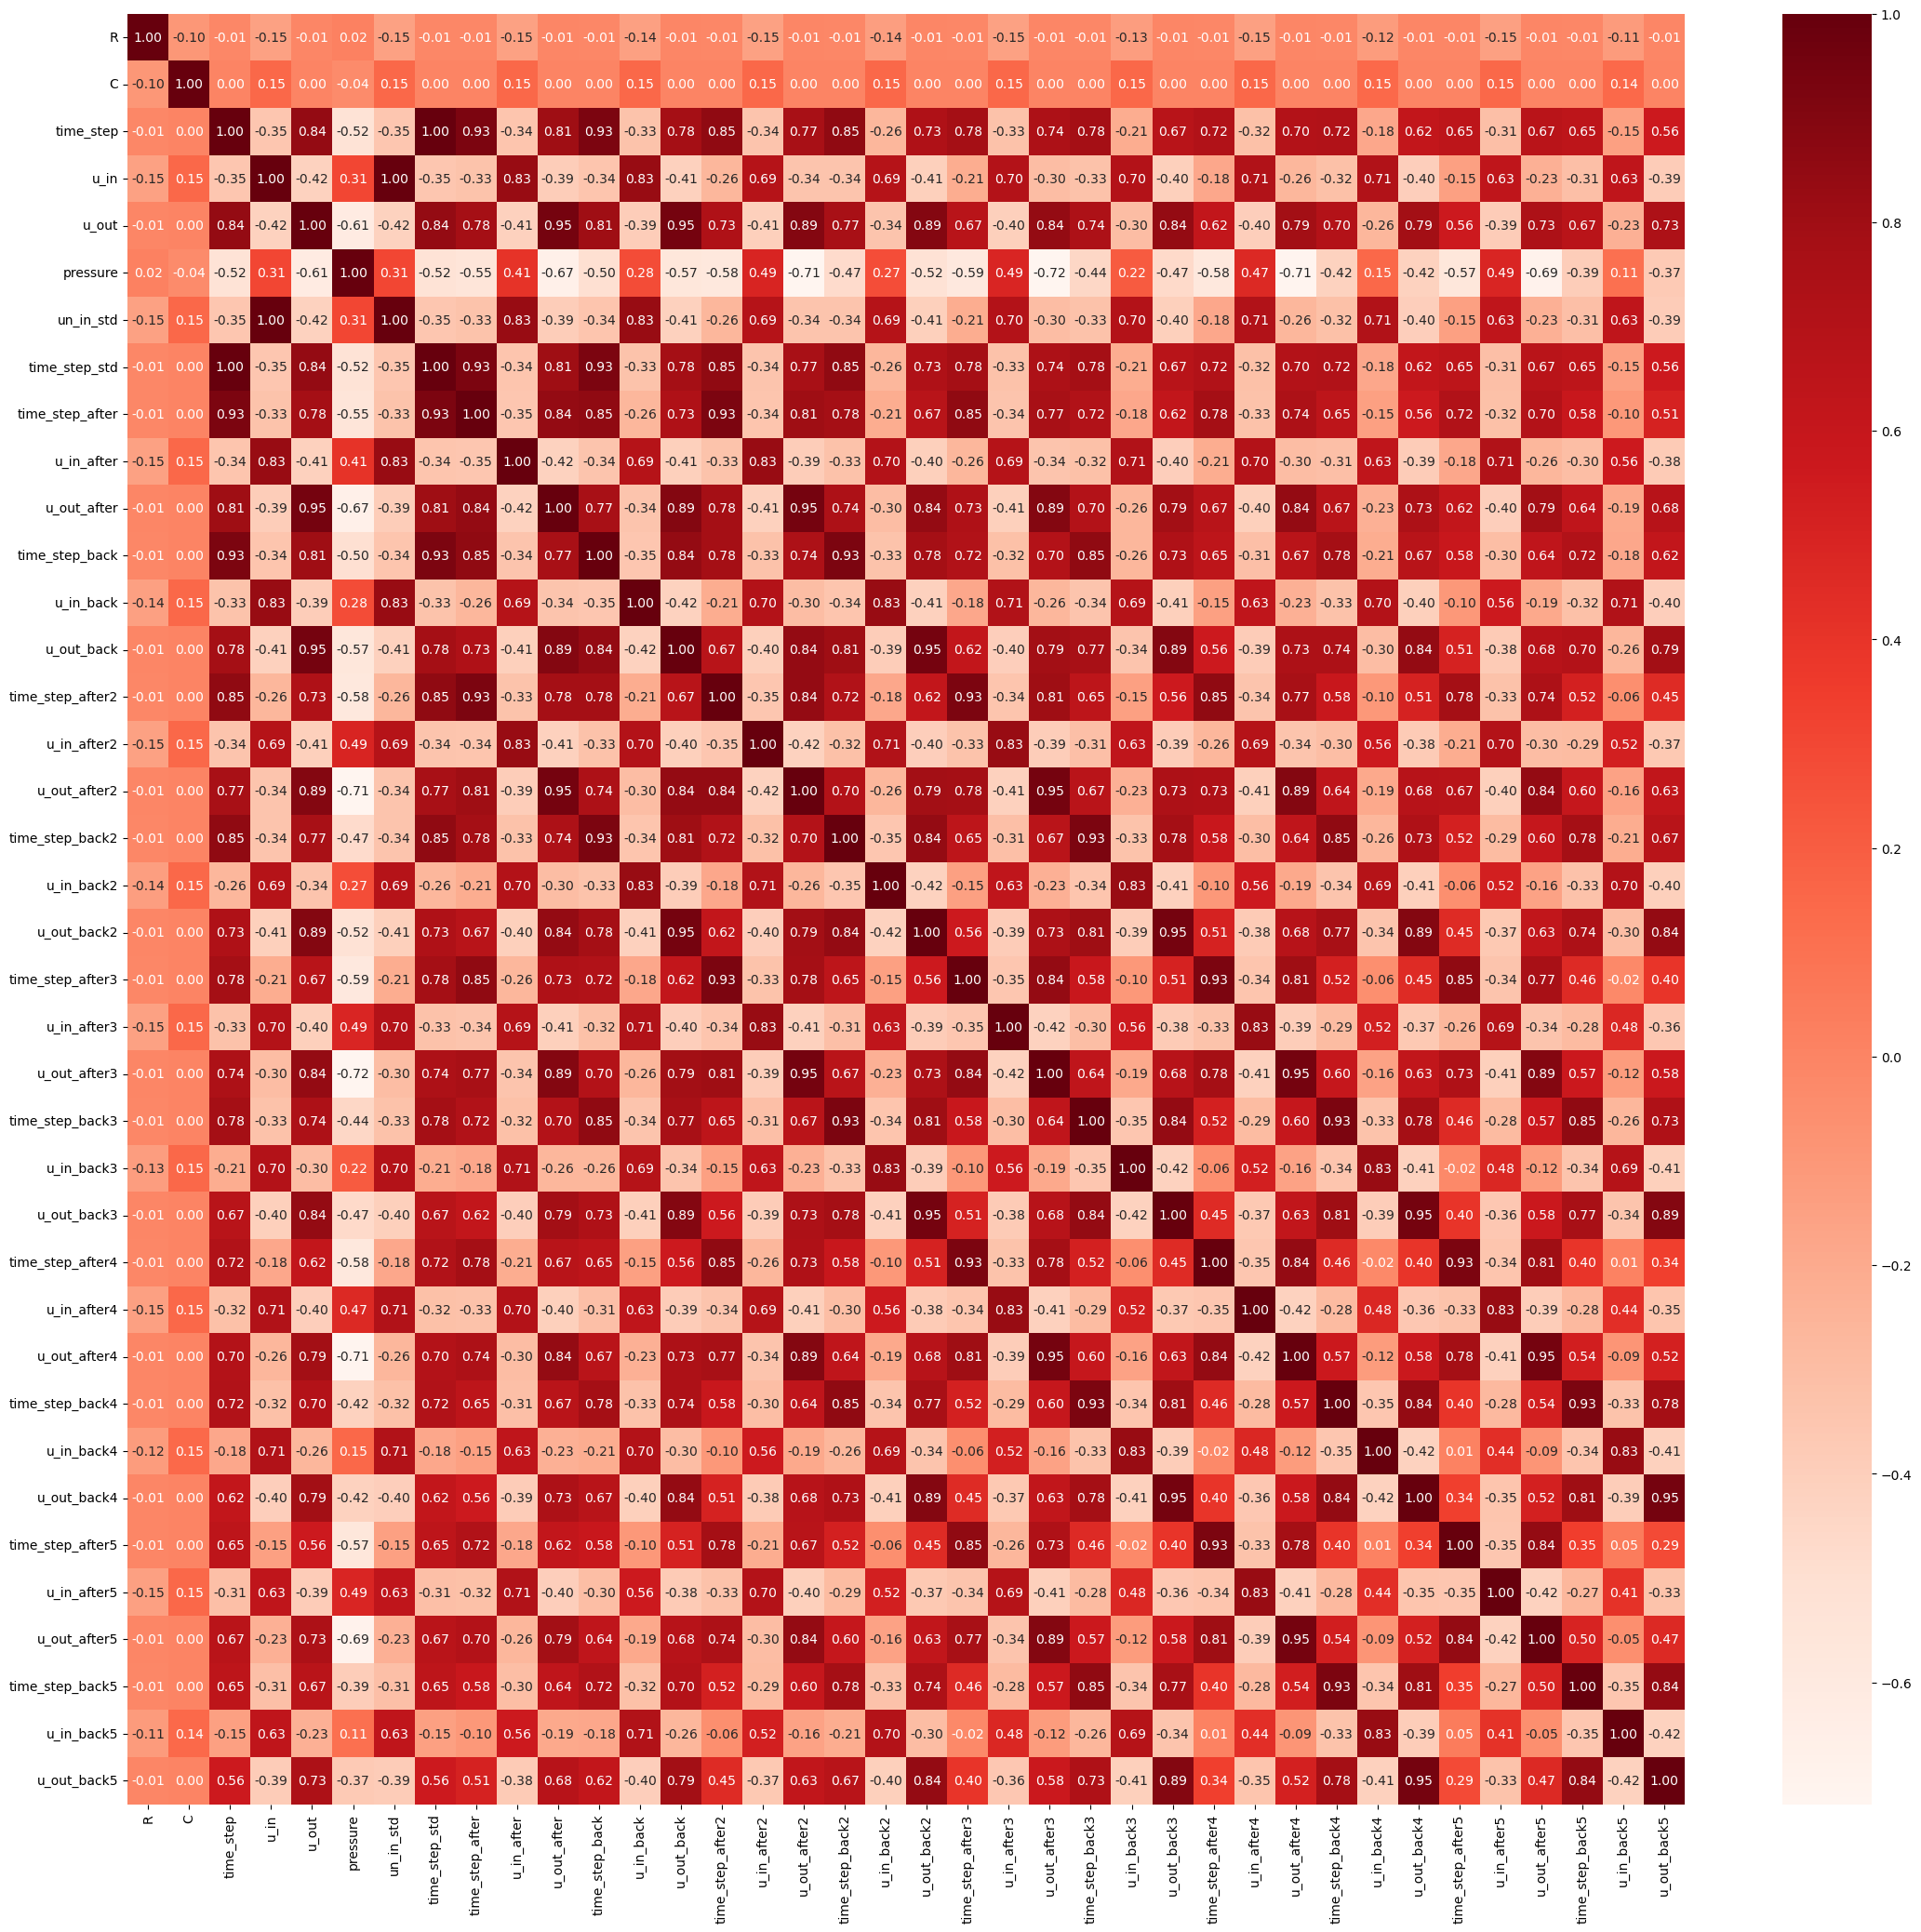

In [26]:
plt.figure(figsize=(27,25))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,fmt='.2f')
plt.show()

# Modeling

**Split dataset**

In [27]:
X = df_train.drop(columns=['pressure'])
y = df_train['pressure']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.98, shuffle=True, random_state=150)
X_val, X_test, y_val, y_test=train_test_split(X_val_test, y_val_test, train_size=0.5, shuffle=True, random_state=150)

**XGBRegressor Model**

In [28]:
XGBModel = XGBRegressor(n_estimators=150, max_depth=11, eta=0.08, subsample=0.6, colsample_bytree=0.8)
XGBModel.fit(X_train, y_train)

print('XGBoost Regressor Train Score is : ' , XGBModel.score(X_train, y_train))
print('XGBoost Regressor Test Score is : ' , XGBModel.score(X_test, y_test))

XGBoost Regressor Train Score is :  0.945280773946217
XGBoost Regressor Test Score is :  0.9430952885044349


In [29]:
CrossValidateValues1 = cross_validate(XGBModel, X_val, y_val, cv=5, return_train_score = True)

# Showing Results
print('Train Score Value : ', CrossValidateValues1['train_score'])
print('Test Score Value : ', CrossValidateValues1['test_score'])
print('Fit Time : ', CrossValidateValues1['fit_time'])
print('Score Time : ', CrossValidateValues1['score_time'])

Train Score Value :  [0.98012743 0.97999437 0.97950622 0.98034132 0.98011313]
Test Score Value :  [0.90961058 0.91474919 0.91394425 0.91100758 0.90942209]
Fit Time :  [30.13793373 30.02087402 30.5667522  30.1623745  30.82820868]
Score Time :  [0.05551577 0.05694771 0.05502462 0.05631995 0.05578828]


In [30]:
y_pred_x = XGBModel.predict(X_test)
MSEValue_X = mean_squared_error(y_test, y_pred_x, multioutput='uniform_average')
print('Mean Squared Error Value by Square root is : ', np.sqrt(MSEValue_X))

Mean Squared Error Value by Square root is :  1.9530729107434124


In [31]:
y_pred_x[55:65], y_test[55:65]

(array([ 7.628685 ,  6.370557 ,  7.47496  ,  7.852884 ,  6.7721868,
         6.4484205,  6.9568653, 22.848606 ,  6.217924 ,  7.567701 ],
       dtype=float32),
 4483486     6.048398
 2071098     5.978096
 4910598     8.508973
 921         8.016858
 3506542     7.313837
 3864859     6.399909
 5856042     6.681117
 2198496    24.467560
 1513572     5.626585
 5196804     7.454441
 Name: pressure, dtype: float64)

**lightgbm Model**

In [32]:
import lightgbm as lgb
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.09,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 4000
}

In [33]:
lgb_regressor = lgb.LGBMRegressor(**params)
lgb_regressor.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='l1', early_stopping_rounds=1000)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.268770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warn

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.09, max_bin=512, max_depth=8, metric=['l1', 'l2'],
              num_iterations=4000, num_leaves=128, objective='regression',
              task='train', verbose=0)

In [34]:
CrossValidateValues2 = cross_validate(lgb_regressor, X_val, y_val, cv=5, return_train_score = True)

# Showing Results
print('Train Score Value : ', CrossValidateValues2['train_score'])
print('Test Score Value : ', CrossValidateValues2['test_score'])
print('Fit Time : ', CrossValidateValues2['fit_time'])
print('Score Time : ', CrossValidateValues2['score_time'])

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [35]:
y_pred_lgb = lgb_regressor.predict(X_test, num_iteration=lgb_regressor.best_iteration_)

print(metrics.r2_score(y_test, y_pred_lgb))

MSEValue_LGB = mean_squared_error(y_test, y_pred_lgb, multioutput='uniform_average')
print('Mean Squared Error Value by Square root is : ', np.sqrt(MSEValue_LGB))

0.9515804512698517
Mean Squared Error Value by Square root is :  1.8015848131339423
